# BRAIN TUMOR DETECTOR

Dataset obtained from: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
import tensorflow as tf
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

2024-06-04 12:10:21.099908: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 12:10:21.500679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:10:22.352622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
SOURCE_DIR = './brain_tumor_dataset/'
ROOT_DIR = './data/'

In [4]:
def create_train_val_dirs(ROOT_DIR):

    if os.path.exists(ROOT_DIR):
        shutil.rmtree(ROOT_DIR)

    os.makedirs(os.path.join(ROOT_DIR, './training/yes'))
    os.makedirs(os.path.join(ROOT_DIR, './training/no'))
    os.makedirs(os.path.join(ROOT_DIR, './validation/yes'))
    os.makedirs(os.path.join(ROOT_DIR, './validation/no'))

create_train_val_dirs(ROOT_DIR)

In [5]:
def print_subdirs(ROOT_DIR):
    for root, dirs, files in os.walk(ROOT_DIR):
        for name in dirs:
            print(os.path.join(root, name))

print_subdirs(ROOT_DIR)

./data/validation
./data/training
./data/validation/no
./data/validation/yes
./data/training/no
./data/training/yes


In [6]:
def split_data(SOURCE_DIR, TRAIN_DIR, VALIDATION_DIR, SPLIT_SIZE):

    all_files = []

    for file in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
            all_files.append(file)
        else:
            print(file + " is zero length, so ignoring.")
    
    np.random.shuffle(all_files)

    SPLIT_POINT = int(len(all_files) * SPLIT_SIZE)

    train_files = all_files[:SPLIT_POINT]
    validation_files = all_files[SPLIT_POINT:]

    for file in train_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(TRAIN_DIR, file)
        copyfile(src, dest)

    for file in validation_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(VALIDATION_DIR, file)
        copyfile(src, dest)

In [7]:
POSITIVE_SOURCE_DIR = './brain_tumor_dataset/yes'
NEGATIVE_SOURCE_DIR = './brain_tumor_dataset/no'

POSITIVE_TRAIN_DIR = './data/training/yes'
NEGATIVE_TRAIN_DIR = './data/training/no'

POSITIVE_VALIDATION_DIR = './data/validation/yes'
NEGATIVE_VALIDATION_DIR = './data/validation/no'

split_size = .8

split_data(POSITIVE_SOURCE_DIR, POSITIVE_TRAIN_DIR, POSITIVE_VALIDATION_DIR, split_size)
split_data(NEGATIVE_SOURCE_DIR, NEGATIVE_TRAIN_DIR, NEGATIVE_VALIDATION_DIR, split_size)

print(f'Positive Images: {len(os.listdir(POSITIVE_SOURCE_DIR))}')
print(f'Negative Images: {len(os.listdir(NEGATIVE_SOURCE_DIR))}')

print(f'Training Positive Images: {len(os.listdir(POSITIVE_TRAIN_DIR))}')
print(f'Training Negative Images: {len(os.listdir(NEGATIVE_TRAIN_DIR))}')

print(f'Validation Positive Images: {len(os.listdir(POSITIVE_VALIDATION_DIR))}')
print(f'Validation Negative Images: {len(os.listdir(NEGATIVE_VALIDATION_DIR))}')

Positive Images: 155
Negative Images: 98
Training Positive Images: 124
Training Negative Images: 78
Validation Positive Images: 31
Validation Negative Images: 20


In [8]:
TRAINING_DIR = './data/training'
VALIDATION_DIR = './data/validation'

In [9]:
def train_val_gens(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=.2,
        height_shift_range=.2,
        zoom_range=.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary'
    )

    return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_gens(TRAINING_DIR, VALIDATION_DIR)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/home/arnav/anaconda3/envs/py311/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-04 12:10:24.485171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 12:10:24.658297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 12:10:24.658343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50


/home/arnav/anaconda3/envs/py311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717483226.684552    4848 service.cc:145] XLA service 0x7f18f801acb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717483226.684591    4848 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-06-04 12:10:26.740809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 12:10:27.004824: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN versio

 6/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5756 - loss: 1.0106

I0000 00:00:1717483230.633707    4848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5840 - loss: 0.8488 - val_accuracy: 0.6275 - val_loss: 0.6230
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6340 - loss: 0.6322 - val_accuracy: 0.6275 - val_loss: 0.6275
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7230 - loss: 0.6087 - val_accuracy: 0.6471 - val_loss: 0.6557
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7232 - loss: 0.6050 - val_accuracy: 0.7059 - val_loss: 0.5910
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7406 - loss: 0.5680 - val_accuracy: 0.6863 - val_loss: 0.6385
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6202 - loss: 0.6304 - val_accuracy: 0.6667 - val_loss: 0.6679
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7077 - loss: 0.6130 - val_accuracy: 0.6078 - val_loss: 0.7566
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6530 - loss: 0.6456 - val_accuracy: 0.6667 - val_loss: 0

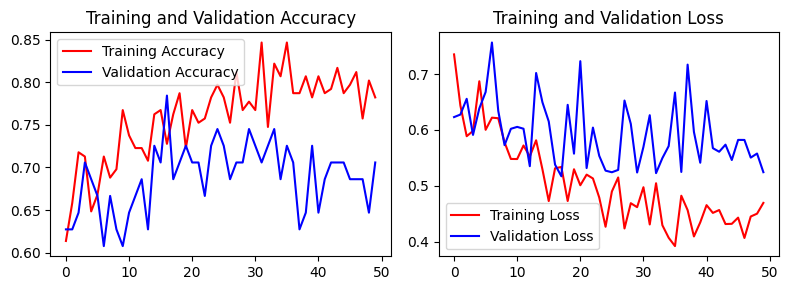

In [15]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)

plt.tight_layout()

In [16]:
model.save('model.h5')

In [17]:
model.save('model.keras')